In [1]:
sc.master

u'local[*]'

In [2]:
global Path    
if sc.master[0:5]=="local" :
    Path="file:/home/hduser/pythonsparkexample/PythonProject/"
else:   
    Path="hdfs://master:9000/user/hduser/"

In [3]:
print("開始匯入資料...")
rawDataWithHeader = sc.textFile(Path+"data/bank.csv")
rawDataWithHeader.take(2)

開始匯入資料...


[u'X1,X2, X3,Y', u'-48.2,6.8,1.6,0']

In [4]:
header = rawDataWithHeader.first() 
rData = rawDataWithHeader.filter(lambda x:x !=header)  
lines = rData.map(lambda x: x.split(","))
print("共計：" + str(lines.count()) + "筆")

共計：30筆


In [5]:
lines.collect()

[[u'-48.2', u'6.8', u'1.6', u'0'],
 [u'-49.2', u'-17.2', u'0.3', u'0'],
 [u'-19.2', u'-36.7', u'0.8', u'0'],
 [u'-18.1', u'-6.5', u'0.9', u'0'],
 [u'-98', u'-20.8', u'1.7', u'0'],
 [u'-129', u'-14.2', u'1.3', u'0'],
 [u'-4', u'-15.8', u'2.1', u'0'],
 [u'-8.7', u'-36.3', u'2.8', u'0'],
 [u'-59.2', u'-12.8', u'2.1', u'0'],
 [u'-13.1', u'-17.6', u'0.9', u'0'],
 [u'-38', u'1.6', u'1.2', u'0'],
 [u'-57.9', u'0.7', u'0.8', u'0'],
 [u'-8.8', u'-9.1', u'0.9', u'0'],
 [u'-64.7', u'-4', u'0.1', u'0'],
 [u'-11.4', u'4.8', u'0.9', u'0'],
 [u'43', u'16.4', u'1.3', u'1'],
 [u'47', u'16', u'1.9', u'1'],
 [u'-3.3', u'4', u'2.7', u'1'],
 [u'35', u'20.8', u'1.9', u'1'],
 [u'46.7', u'12.6', u'0.9', u'1'],
 [u'20.8', u'12.5', u'2.4', u'1'],
 [u'33', u'23.6', u'1.5', u'1'],
 [u'26.1', u'10.4', u'2.1', u'1'],
 [u'68.6', u'13.8', u'1.6', u'1'],
 [u'37.3', u'33.4', u'3.5', u'1'],
 [u'59', u'23.1', u'5.5', u'1'],
 [u'49.6', u'23.8', u'1.9', u'1'],
 [u'12.5', u'7', u'1.8', u'1'],
 [u'37.3', u'34.1', u'1.5', u'1

In [6]:
import numpy as np
def extract_features(field,featureEnd):
    #擷取分類特徵欄位
       #第3个欄位不是特徵欄位
    numericalFeatures=[float(id)  for  id in field[0:2]]    
    #回傳「分類特徵欄位」
    return numericalFeatures


def extract_label(field):
    label=(field[-1])
    return float(label)

In [7]:
labelRDD = lines.map( lambda r: extract_label(r))
print labelRDD.collect()

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [8]:
from pyspark.mllib.regression import LabeledPoint
labelpointRDD = lines.map( lambda r: 
     LabeledPoint(
                extract_label(r),
                extract_features(r,len(r) - 1)))

In [9]:
labelpointRDD.take(2)
trainData=labelpointRDD
trainData.persist()

PythonRDD[8] at RDD at PythonRDD.scala:48

In [10]:
from pyspark.mllib.tree import DecisionTree
model=DecisionTree.trainClassifier( \
        trainData, numClasses=2, categoricalFeaturesInfo={}, \
        impurity="entropy", maxDepth=5, maxBins=5)

In [11]:
predictResult = model.predict([-25,2.5,0.5])  ###(X1,X2,X3) = [-25,2.5,0.5]

In [12]:
predictResult

0.0

In [10]:
  #-----------3.以隨機方式將資料分為3部份並且回傳-------------
(trainData, validationData, testData) = labelpointRDD.randomSplit([6, 2, 2])
print("trainData:" + str(trainData.count()) +   
            "   validationData:" + str(validationData.count()) + 
            "   testData:" + str(testData.count()))



trainData:16   validationData:5   testData:9


In [11]:
trainData.persist()
validationData.persist()
testData.persist()

PythonRDD[14] at RDD at PythonRDD.scala:48

In [12]:
from pyspark.mllib.tree import DecisionTree
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from time import time

# print out the comparison of true & prediction 
def PredictData(RDD,model): 
    for data in RDD.take(5):
        predictResult = model.predict(data.features)
        print " True label：  " +str(data.label)+"\n" +\
                  "             ==>Predict label:"+ str(predictResult)

# get the AUC score of a given model
def evaluateModel(model, validationData):
    score = model.predict(validationData.map(lambda p: p.features))
    scoreAndLabels=score.zip(validationData.map(lambda p: p.label))
    metrics = BinaryClassificationMetrics(scoreAndLabels)
    AUC=metrics.areaUnderROC
    return (AUC)

# build model with the given parameters & get the AUC score
def trainEvaluateModel(trainData,validationData,
                                        impurityParm, maxDepthParm, maxBinsParm):
    startTime = time()
    model = DecisionTree.trainClassifier(trainData,
                numClasses=2, categoricalFeaturesInfo={}, impurity=impurityParm,
                maxDepth=maxDepthParm, maxBins=maxBinsParm)
    AUC = evaluateModel(model, validationData)
    duration = time() - startTime
    return (AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)

# try different group of parameters & return the best model
def evalAllParameter(trainData, validationData, 
                     impurityList, maxDepthList, maxBinsList):    

    metrics = [trainEvaluateModel(trainData, validationData,  
                            impurity,maxDepth,  maxBins  ) 
                      for impurity in impurityList 
                      for maxDepth in maxDepthList  
                      for  maxBins in maxBinsList ]
    
    Smetrics = sorted(metrics, key=lambda k: k[0], reverse=True)
    bestParameter=Smetrics[0]
    print("調校後最佳參數：impurity:" + str(bestParameter[2]) + 
                                      ",maxDepth:" + str(bestParameter[3]) + 
                                     ",maxBins:" + str(bestParameter[4])   + 
                                      "\n"+"AUC = " + str(bestParameter[0]))
    return bestParameter[5]

In [13]:
# performance on validation data
(AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)=  \
       trainEvaluateModel(trainData, validationData, "entropy", 5, 5)
print("validationData,  AUC: " + str(AUC))

validationData,  AUC: 1.0


In [14]:
# performance on test data
(AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)=  \
       trainEvaluateModel(trainData, testData, "entropy", 5, 5)
print("testData,  AUC: " + str(AUC))

testData,  AUC: 1.0


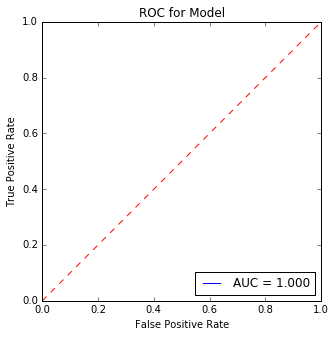

In [15]:
from sklearn import metrics
import warnings;warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline 

y = [ i.label for i in testData.collect()]
pred = [model.predict(i.features) for i in testData.collect()]

fpr, tpr, threshold = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(5,5))
plt.title('ROC for Model')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')  # (0,0) (1,1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# model -> predict -> evaluate

In [14]:
from pyspark.mllib.tree import DecisionTree
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from time import time

# print out the comparison of true & prediction 
def PredictData(RDD,model): 
    for data in RDD.take(5):
        predictResult = model.predict(data.features)
        print " True label：  " +str(data.label)+"\n" +\
                  "             ==>Predict label:"+ str(predictResult)

# get the AUC score of a given model
def evaluateModel(model, validationData):
    score = model.predict(validationData.map(lambda p: p.features))
    scoreAndLabels=score.zip(validationData.map(lambda p: p.label))
    metrics = BinaryClassificationMetrics(scoreAndLabels)
    AUC=metrics.areaUnderROC
    return (AUC)

# build model with the given parameters & get the AUC score
def trainEvaluateModel(trainData,validationData,
                                        impurityParm, maxDepthParm, maxBinsParm):
    startTime = time()
    model = DecisionTree.trainClassifier(trainData,
                numClasses=2, categoricalFeaturesInfo={}, impurity=impurityParm,
                maxDepth=maxDepthParm, maxBins=maxBinsParm)
    AUC = evaluateModel(model, validationData)
    duration = time() - startTime
    return (AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)

# try different group of parameters & return the best model
def evalAllParameter(trainData, validationData, 
                     impurityList, maxDepthList, maxBinsList):    

    metrics = [trainEvaluateModel(trainData, validationData,  
                            impurity,maxDepth,  maxBins  ) 
                      for impurity in impurityList 
                      for maxDepth in maxDepthList  
                      for  maxBins in maxBinsList ]
    
    Smetrics = sorted(metrics, key=lambda k: k[0], reverse=True)
    bestParameter=Smetrics[0]
    print("調校後最佳參數：impurity:" + str(bestParameter[2]) + 
                                      ",maxDepth:" + str(bestParameter[3]) + 
                                     ",maxBins:" + str(bestParameter[4])   + 
                                      "\n"+"AUC = " + str(bestParameter[0]))
    return bestParameter[5]

In [18]:
print("-----所有參數訓練評估找出最好的參數組合---------")  
bestModel=evalAllParameter(trainData, validationData,
                        ["gini", "entropy"],
                        [3, 5, 10, 15, 20, 25], 
                        [3, 5, 10, 15, 20, 25])

-----所有參數訓練評估找出最好的參數組合---------
調校後最佳參數：impurity:gini,maxDepth:3,maxBins:3
AUC = 1.0


In [19]:
AUC=evaluateModel(bestModel, testData)
print "AUC = "+str(AUC)
print "\n"
print("-----預測資料-----")
PredictData(testData,bestModel)

AUC = 1.0


-----預測資料-----
 True label：  0.0
             ==>Predict label:0.0
 True label：  1.0
             ==>Predict label:1.0
 True label：  1.0
             ==>Predict label:1.0
 True label：  1.0
             ==>Predict label:1.0
 True label：  1.0
             ==>Predict label:1.0


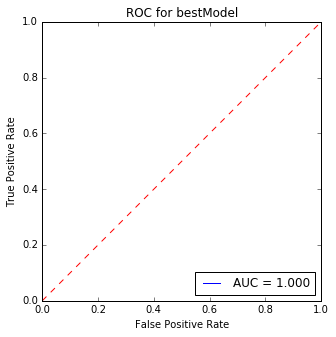

In [20]:
from sklearn import metrics
import warnings;warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline 

y = [ i.label for i in testData.collect()]
pred = [bestModel.predict(i.features) for i in testData.collect()]

fpr, tpr, threshold = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(5,5))
plt.title('ROC for bestModel')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')  # (0,0) (1,1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()